In [ ]:
# 0. 執行指令:
#      !python predict.py -c config.json -i /path/to/image/or/video  
#      輸入為 圖片: !python predict.py -c config.json -i ./o_input
#      輸入為 影片: !python predict.py -c config.json -i ./o_input/Produce.mp4  

1. 輸入檔案擺放位置:
     將要偵測的 影片或圖片 放到 資料夾 o_input (影片必須為mp4格式；圖片可以多張，必須為 '.jpg','.JPG','.png','JPEG' 格式)。
2. 程式設定: 
     (第17行) 假設 影片名稱為Produce.mp4，則 input_path   = './o_input/Produce.mp4'。
     (第17行) 假設 要偵測圖片(可以多張)，則 input_path   = './o_input/' 。
    
     (第34行) infer_model = load_model('kholes_448_an_ne4.h5') 
                 model 為 kholes_448_an_ne4.h5，大於100M，無法上傳github。
                 下載點: https://drive.google.com/file/d/1wbhtz99RANQ2-EDhSCW3hKhsHSrHWXw3/view?usp=sharing。
3. 輸出結果:
     執行結束後，輸出會在 資料夾 output。6秒鐘的影片，大約需要9分鐘；一張圖片，約3秒鐘(在很普通的筆電)。
4. 資料蒐集:
     使用 A8+ 手機。
5. 測試環境:
     windows。
6. 取消utils/bbox.py的所有註解，會輸出bounding box的座標與 類別(["hole", "square", "repair"] #   ["圓孔蓋", "方孔蓋", "修補"])。

D:\00work\ana352\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
D:\00work\ana352\lib\site-packages\keras\engine\saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


./o_input/picture01.png
./o_input/picture02.png
./o_input/picture03.png
./o_input/picture04.png
./o_input/picture05.png
執行時間: 00:00:32


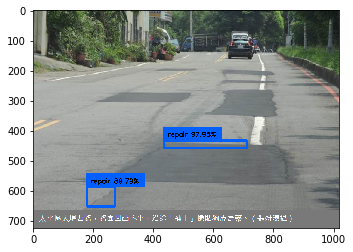

In [1]:
# -*- coding: utf-8 -*- 
# predict
import os
import argparse
import json
import cv2
from utils.utils import get_yolo_boxes, makedirs
from utils.bbox import draw_boxes
from keras.models import load_model
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# ./o_input/
input_path   = './o_input/' # 影片輸入設定: input_path = './o_input/test.mp4' 
output_path  = 'output/'
makedirs(output_path)

# Set some parameter
net_h, net_w = 608, 608 # a multiple of 32, the smaller the faster 
obj_thresh, nms_thresh = 0.5, 0.45
# anchors = [15,15, 19,46, 40,101, 42,22, 81,41, 84,15, 125,71, 181,33, 196,118]
anchors = [15,15, 20,39, 24,104, 46,20, 48,50, 69,109, 98,28, 114,58, 179,104]
labels = ["hole", "square", "repair", "crack"] # TIGER    ["圓孔蓋", "方孔蓋", "修補","龜裂"]
# labels = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"] # TIGER

# Load the model
# print("b")
infer_model = load_model('kholes_608_ang_ne.h5')  

start_time = time.time()
# Predict bounding boxes 
if input_path[-4:] == '.mp4': # do detection on a video  
    video_out = output_path + input_path.split('/')[-1]
    video_reader = cv2.VideoCapture(input_path)

    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

#     fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    video_writer = cv2.VideoWriter(video_out,
                           cv2.VideoWriter_fourcc(*'H264'), 
                           30.0, 
                           (frame_w, frame_h))
    # the main loop
    batch_size  = 1
    images      = []
    start_point = 0 #%
    show_window = False
    for i in tqdm(range(nb_frames)):
        _, image = video_reader.read()
        if image is None:
            continue
        if (float(i+1)/nb_frames) > start_point/100.:
            images += [image]

            if (i%batch_size == 0) or (i == (nb_frames-1) and len(images) > 0):
                # predict the bounding boxes
                batch_boxes = get_yolo_boxes(infer_model, images, net_h, net_w, anchors, obj_thresh, nms_thresh)

                for i in range(len(images)):
                    # draw bounding boxes on the image using labels
                    draw_boxes(images[i], batch_boxes[i], labels, obj_thresh)   

                    # show the video with detection bounding boxes          
                    if show_window: cv2.imshow('video with bboxes', images[i])  

                    # write result to the output video
                    video_writer.write(images[i]) 
                images = []
            if show_window and cv2.waitKey(1) == 27: break  # esc to quit

    if show_window: cv2.destroyAllWindows()
    video_reader.release()
    video_writer.release()           
else: # do detection on an image or a set of images
    image_paths = []

    if os.path.isdir(input_path): 
        for inp_file in os.listdir(input_path):
            image_paths += [input_path + inp_file]
    else:
        image_paths += [input_path]

    image_paths = [inp_file for inp_file in image_paths if (inp_file[-4:] in ['.jpg','.JPG', '.png', 'JPEG'])]

    # the main loop
    for image_path in image_paths:
        image = cv2.imread(image_path)
        print(image_path)

        # predict the bounding boxes
        boxes = get_yolo_boxes(infer_model, [image], net_h, net_w, anchors, obj_thresh, nms_thresh)[0]

        # draw bounding boxes on the image using labels
        draw_boxes(image, boxes, labels, obj_thresh) 

        # write the image with bounding boxes to file
        output_img_path = output_path + image_path.split('/')[-1]
        cv2.imwrite(output_img_path, np.uint8(image))
        img = cv2.imread(output_img_path)[:,:,::-1]
        plt.imshow(img)
        
elapsed_time = time.time() - start_time
print("執行時間: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)) )